# Analysis of COVID-19 infections data in Italy

## Authors:
> **Jacopo Bartoli**  
> Università degli Studi di Firenze - Scuola di Ingegneria  
> jacopo.bartoli@stud.unifi.it  

> **Jason Ravagli**  
> Università degli Studi di Firenze - Scuola di Ingegneria  
> jason.ravagli@stud.unifi.it

---

## Outline
1. Introduction
2. Section 2
3. Section 3
4. ...

---

## 1. Introduction
We are all aware of the situation that the COVID-19 pandemic has caused in Italy during 2020. Starting from March 2020, the Italian Civil Protection (ICP) has begun to gather and make available daily data about contagious (such as the number of new positives, hospitalized infected, deaths, etc..) in our country to inform the population.

In addition to using the usual communication channels, the ICP created a [GitHub repository](https://github.com/pcm-dpc/COVID-19) to publish all the data and make them usable to research purposes. The main contributor to this repository is Umberto Rosini (https://github.com/umbros), an employee of the ICP.

The repository contains various kinds of data regarding the emergency and the infection, but in this notebook we focus on the analysis of two data files:

- https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-province.json
- https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-regioni.json

They contain the data about contagion day by day since 24th February 2020 and, at the time of writing (21st August 2020), they are updated every day at 18:30.  
The first file contains data divided by province, while the second one contains data divided by region.

**Summary**

### Setup environment

Importing required libraries:

In [70]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Define a function that allows to display multiple objects (e.g. dataframes) side by side:

In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 2. Loading data

### Loading data as list of dictionaries

Inspecting the JSON files, we can observe that in each of them data are stored as an array of JSON objects. Therefore, we can load data in a list of Python dictionaries to take a first look at their structure.

In [3]:
with open("data/dpc-covid19-ita-regioni.json") as f:
    list_dict_reg = json.load(f)

In [4]:
with open("data/dpc-covid19-ita-province.json") as f:
    list_dict_prov = json.load(f)

In [5]:
list_dict_reg[0]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'lat': 42.35122196,
 'long': 13.39843823,
 'ricoverati_con_sintomi': 0,
 'terapia_intensiva': 0,
 'totale_ospedalizzati': 0,
 'isolamento_domiciliare': 0,
 'totale_positivi': 0,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 0,
 'dimessi_guariti': 0,
 'deceduti': 0,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 0,
 'tamponi': 5,
 'casi_testati': None,
 'note': None}

In [6]:
list_dict_prov[0]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'codice_provincia': 66,
 'denominazione_provincia': "L'Aquila",
 'sigla_provincia': 'AQ',
 'lat': 42.35122196,
 'long': 13.39843823,
 'totale_casi': 0,
 'note': None}

Each data object contains information about the cases of COVID-19 in a particular day for each region/province.
Data about regions contain exhaustive information about the detected cases, and a full explanation of each data field can be found [here](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-covid19-italia.md).

However it is not clear what the field *totale_casi* in the province data is about. In particular, from the documentation it is not clear if it refers to the currently positive cases in that province or to the overall detected cases.

### Loading data as Pandas dataframe

In [7]:
df_reg = pd.DataFrame(list_dict_reg)

In [8]:
df_prov = pd.DataFrame(list_dict_prov)

---

Let us take an overview at the region data.

In [9]:
df_reg.shape

(3738, 21)

In [10]:
df_reg.dtypes

data                             object
stato                            object
codice_regione                    int64
denominazione_regione            object
lat                             float64
long                            float64
ricoverati_con_sintomi            int64
terapia_intensiva                 int64
totale_ospedalizzati              int64
isolamento_domiciliare            int64
totale_positivi                   int64
variazione_totale_positivi        int64
nuovi_positivi                    int64
dimessi_guariti                   int64
deceduti                          int64
casi_da_sospetto_diagnostico    float64
casi_da_screening               float64
totale_casi                       int64
tamponi                           int64
casi_testati                    float64
note                             object
dtype: object

In [11]:
df_reg.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,0,0,0,0,NaN,NaN,0,5,NaN,None
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,None
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,0,0,0,0,NaN,NaN,0,1,NaN,None
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,0,0,0,0,NaN,NaN,0,10,NaN,None
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,0,18,0,0,NaN,NaN,18,148,NaN,None


In [12]:
df_reg.describe()

,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,1176.000000,1176.000000,3738.000000,3.738000e+03,2583.000000
mean,11.857143,43.046293,12.225955,444.334136,50.146602,494.480738,1557.240770,2051.721509,4.050027,68.313002,5435.201980,1208.643125,10614.001701,1097.881803,8695.566613,1.607540e+05,137174.008904
std,6.274638,2.489114,2.659303,1323.771538,140.420552,1459.140050,3563.133122,4776.091041,185.709468,199.965627,11458.321257,2992.315037,19311.460927,1798.906944,17203.130676,2.438840e+05,145445.090715
min,1.000000,38.115697,7.320149,0.000000,0.000000,0.000000,0.000000,0.000000,-5339.000000,-229.000000,0.000000,0.000000,400.000000,0.000000,0.000000,0.000000e+00,3482.000000
25%,7.000000,41.125596,11.121231,9.000000,0.000000,10.000000,72.000000,87.250000,-12.000000,1.000000,245.250000,64.000000,1433.000000,17.000000,1100.000000,1.589075e+04,43673.500000
50%,12.000000,43.616760,12.388247,56.000000,5.000000,63.000000,320.000000,398.000000,0.000000,9.000000,1351.000000,291.000000,3348.000000,191.500000,3154.500000,7.786100e+04,83144.000000
75%,17.000000,45.434905,13.768136,255.000000,36.000000,294.000000,1313.750000,1648.250000,14.000000,48.000000,4404.000000,870.000000,8614.500000,1579.000000,7549.500000,1.888848e+05,182034.500000
max,22.000000,46.499335,16.867367,12077.000000,1381.000000,13328.000000,30382.000000,37307.000000,1950.000000,3251.000000,75398.000000,16844.000000,90487.000000,7485.000000,97564.000000,1.432476e+06,855372.000000


---

Now let us do the same thing for the province data.

In [13]:
df_prov.shape

(23960, 11)

In [14]:
df_prov.dtypes

data                        object
stato                       object
codice_regione               int64
denominazione_regione       object
codice_provincia             int64
denominazione_provincia     object
sigla_provincia             object
lat                        float64
long                       float64
totale_casi                  int64
note                        object
dtype: object

In [15]:
df_prov.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,None
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,None
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,None
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,None
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,None,NaN,NaN,0,None


In [16]:
df_prov.describe()

,codice_regione,codice_provincia,lat,long,totale_casi
count,23960.000000,23960.000000,19046.000000,19046.000000,23960.000000
mean,10.499499,240.971536,42.908522,12.096599,1356.585935
std,6.053899,369.370866,2.631578,2.660616,2748.219583
min,1.000000,1.000000,36.925092,7.320149,0.000000
25%,5.000000,34.000000,40.914047,9.828190,59.000000
50%,9.000000,68.000000,43.715532,12.104734,424.000000
75%,16.000000,101.000000,45.185093,14.167546,1367.000000
max,22.000000,999.000000,46.499335,18.171897,25297.000000


### Cleaning and preparing data

From the above tables we can observe that there are some useless data in both dataframes.
First of all we can drop the column `stato` from both, since the data all refer to the Italy (we can verify that `ITA` is the unique value).

In [17]:
df_reg['stato'].unique(), df_prov['stato'].unique()

(array(['ITA'], dtype=object), array(['ITA'], dtype=object))

In [18]:
df_reg = df_reg.drop(columns=["stato"])
df_prov = df_prov.drop(columns=["stato"])

Also the field `note` can be removed from the regions dataframe since it contains not useful plain textual data.

In [19]:
df_reg["note"].unique()

array([None, 'pd-IT-0002', 'pd-IT-0004', 'nd-IT-0001', 'nd-IT-0003',
       'nd-IT-0005', 'nd-IT-0008', 'nd-IT-0013', 'nd-IT-0011',
       'pd-IT-0006', 'pd-IT-0008', 'pd-IT-0010', 'dc-IT-0002',
       'dc-IT-0004', 'dc-IT-0006', 'pd-IT-0012', 'pd-IT-0014',
       'pd-IT-0016', 'dc-IT-0008', 'dc-IT-0010', 'dc-IT-0012',
       'dc-IT-0014', 'dc-IT-0016', 'dc-IT-0018', 'dc-IT-0020',
       'dc-IT-0022', 'dc-IT-0024', 'dc-IT-0026', 'dc-IT-0028',
       'dc-IT-0030', 'pd-IT-0018', 'dc-IT-0032', 'pd-IT-0020',
       'dc-IT-0034', 'dc-IT-0036', 'nd-IT-0015', 'pd-IT-0022',
       'dc-IT-0037', 'dc-IT-0038', 'dc-IT-0040', 'dc-IT-0042',
       'dc-IT-0046', 'dc-IT-0044', 'dc-IT-0048', 'dc-IT-0050',
       'dc-IT-0052', 'dc-IT-0054', 'dc-IT-0056', 'dc-EN-0058',
       'dc-IT-0062', 'dc-IT-0060', 'dc-IT-0064', 'dc-IT-0066',
       'dc-IT-0068', 'dc-IT-0070',
       'n.3 decessi precedentemente segnalati, da una revisione non risultano classificabili come COVID-19 positivi',
       'NEI CASI POSIT

In [64]:
df_prov["note"].unique()

array([None, 'pd-IT-0001', 'nd-IT-0007', 'nd-IT-0010', 'dc-IT-0001',
       'di cui 24 Stato estero', 'di cui 66 stato estero',
       "NEL TOTALE CASI POSITIVI SONO COMPRESI ULTERIORI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, ASINTOMATICI ED  IN ISOLAMENTO DOMICILIARE, NON RESIDENTI E PROVENIENTI DA STATO ESTERO.  ",
       "NEL TOTALE CASI POSITIVI SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, ASINTOMATICI ED  IN ISOLAMENTO DOMICILIARE, NON RESIDENTI E PROVENIENTI DA STATO ESTERO.  ",
       ' ',
       "NEL TOTALE CASI POSITIVI SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, PROVENIENTI DA STATO ESTERO.  ",
       'N. 1 NUOVO CASO POSITIVO DA SCREENING DI SOGGETTO RESIDENTE IN BASILICATA MA PROVENIENTE DA STATO ESTERO OVE SOGGIORNA PER MOTIVI DI LAVORO (KAZAKISTAN)',
       "NEL TOTALE CASI POSITIVI DA ATTIVITA' DI SCREENING SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI, PROVENIENTI DA STATO ESTERO (MOLDAVIA

In [20]:
df_reg = df_reg.drop(columns=["note"])
df_prov = df_prov.drop(columns=["note"])

Looking at the column types, we can see that the data under the columns `data` are stored as `object` in both dataframes. It is more appropriate to use the pandas `Timestamp` type, to facilitate queries.  
According to the documentation and to the size of data, for each day and region (for each day and province for the provinces dataframe) there is a unique entry, so for simplicity we can keep only the date without the time normalizing the column.

In [21]:
df_reg["data"] = pd.DatetimeIndex(df_reg["data"]).normalize()
df_prov["data"] = pd.DatetimeIndex(df_prov["data"]).normalize()

Finally, it would be useful for the next analysis to modify the indexes to use a multi-index with the date and regions for the regions data and a multi-index with the date and provinces for the provinces ones.

In [22]:
df_reg.set_index(["data", "denominazione_regione"], inplace=True)
df_prov.set_index(["data", "denominazione_regione", "sigla_provincia"], inplace=True)

Let us look at the obtained data:

## !!! Guarda il df delle province: NaN nell'index, droppare i dati non assegnati?

In [62]:
df_reg.tail()

codice_regione        lat       long  \
data       denominazione_regione                                         
2020-08-19 Sicilia                            19  38.115697  13.362357   
           Toscana                             9  43.769231  11.255889   
           Umbria                             10  43.106758  12.388247   
           Valle d'Aosta                       2  45.737503   7.320149   
           Veneto                              5  45.434905  12.338452   

                                  ricoverati_con_sintomi  terapia_intensiva  \
data       denominazione_regione                                              
2020-08-19 Sicilia                                    53                  8   
           Toscana                                    20                  5   
           Umbria                                      9                  2   
           Valle d'Aosta                               1                  0   
           Veneto                                     39                  6   

                                  totale_ospedalizzati  \
data       denominazione_regione                         
2020-08-19 Sicilia                                  61   
           Toscana                                  25   
           Umbria                                   11   
           Valle d'Aosta                             1   
           Veneto                                   45   

                                  isolamento_domiciliare  totale_positivi  \
data       denominazione_regione                                            
2020-08-19 Sicilia                                   705              766   
           Toscana                                   721              746   
           Umbria                                     84               95   
           Valle d'Aosta                               9               10   
           Veneto                                   1616             1661   

                                  variazione_totale_positivi  nuovi_positivi  \
data       denominazione_regione                                               
2020-08-19 Sicilia                                        44              45   
           Toscana                                        28              40   
           Umbria                                          2               4   
           Valle d'Aosta                                   2               2   
           Veneto                                        -27              59   

                                  dimessi_guariti  deceduti  \
data       denominazione_regione                              
2020-08-19 Sicilia                           2786       286   
           Toscana                           9040      1139   
           Umbria                            1388        80   
           Valle d'Aosta                     1064       146   
           Veneto                           17615      2099   

                                  casi_da_sospetto_diagnostico  \
data       denominazione_regione                                 
2020-08-19 Sicilia                                      3009.0   
           Toscana                                     10460.0   
           Umbria                                       1481.0   
           Valle d'Aosta                                1102.0   
           Veneto                                      19745.0   

                                  casi_da_screening  totale_casi  tamponi  \
data       denominazione_regione                                            
2020-08-19 Sicilia                            829.0         3838   315870   
           Toscana                            465.0        10925   479103   
           Umbria                              82.0         1563   136524   
           Valle d'Aosta                      118.0         1220    23634   
           Veneto                            1630.0        21375  1403390   

        

In [63]:
df_prov.tail()

codice_regione  \
data       denominazione_regione sigla_provincia                   
2020-08-19 Veneto                VE                            5   
                                 PD                            5   
                                 RO                            5   
                                 NaN                           5   
                                 NaN                           5   

                                                  codice_provincia  \
data       denominazione_regione sigla_provincia                     
2020-08-19 Veneto                VE                             27   
                                 PD                             28   
                                 RO                             29   
                                 NaN                           899   
                                 NaN                           999   

                                                               denominazione_provincia  \
data       denominazione_regione sigla_provincia                                         
2020-08-19 Veneto                VE                                            Venezia   
                                 PD                                             Padova   
                                 RO                                             Rovigo   
                                 NaN                Fuori Regione / Provincia Autonoma   
                                 NaN              In fase di definizione/aggiornamento   

                                                        lat       long  \
data       denominazione_regione sigla_provincia                         
2020-08-19 Veneto                VE               45.434905  12.338452   
                                 PD               45.406930  11.876087   
                                 RO               45.071073  11.790070   
                                 NaN                    NaN        NaN   
                                 NaN                    NaN        NaN   

                                                  totale_casi  note  
data       denominazione_regione sigla_provincia                     
2020-08-19 Veneto                VE                      3047  None  
                                 PD                      4476  None  
                                 RO                       501  None  
                                 NaN                      333  None  
                                 NaN                       38  None

## 3. Analysis of national data

As a first step, let us analyze the data from a national point of view.

The simplest and obvious statistics to examine are the total number of deaths, healed and infected since the beginning of the pandemic and the death rate.

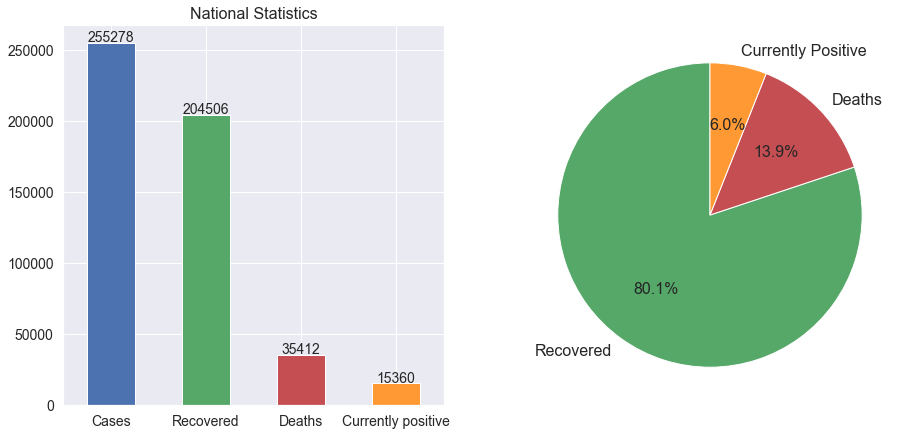

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))

last_day = df_reg.index.max()[0]
tot_cases = df_reg.loc[last_day, "totale_casi"].sum()
tot_recovered = df_reg.loc[last_day, "dimessi_guariti"].sum()
tot_deaths = df_reg.loc[last_day, "deceduti"].sum()
currently_positive = tot_cases - (tot_recovered + tot_deaths)
index = ["Cases", "Recovered", "Deaths", "Currently positive"]

series = pd.Series([tot_cases, tot_recovered, tot_deaths, currently_positive], index=index)

color_list = ["b", "g", "r", "#ff9933"]
ax = series.plot(kind='bar', title="National Statistics", ax=axes[0], color=color_list, rot=0, fontsize=14)
ax.title.set_size(16)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), fontsize=14,
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

index = ["Recovered", "Deaths", "Currently Positive"]
series = pd.Series([tot_recovered, tot_deaths, currently_positive], index = index)
color_list = ["g", "r", "#ff9933"]
ax = series.plot(kind='pie', ax=axes[1], colors=color_list, autopct='%1.1f%%',
        startangle=90, shadow=False, legend = False, fontsize=16)
ax.set_ylabel(None);


Since the beginning of the emergency the ICP registered that in Italy more than 250 thousand have been infected by COVID-19, with more than 35 thousand of victims (13.9% mortality).  
This death rate may appear huge, but doing some research it can be found that ICP data does not take into consideration the serological tests conducted by the ASLs. These tests revealed a lot of healed asymptomatic subjects that did not know they had been infected.

---

It could be interesting to study the national data trend over time.

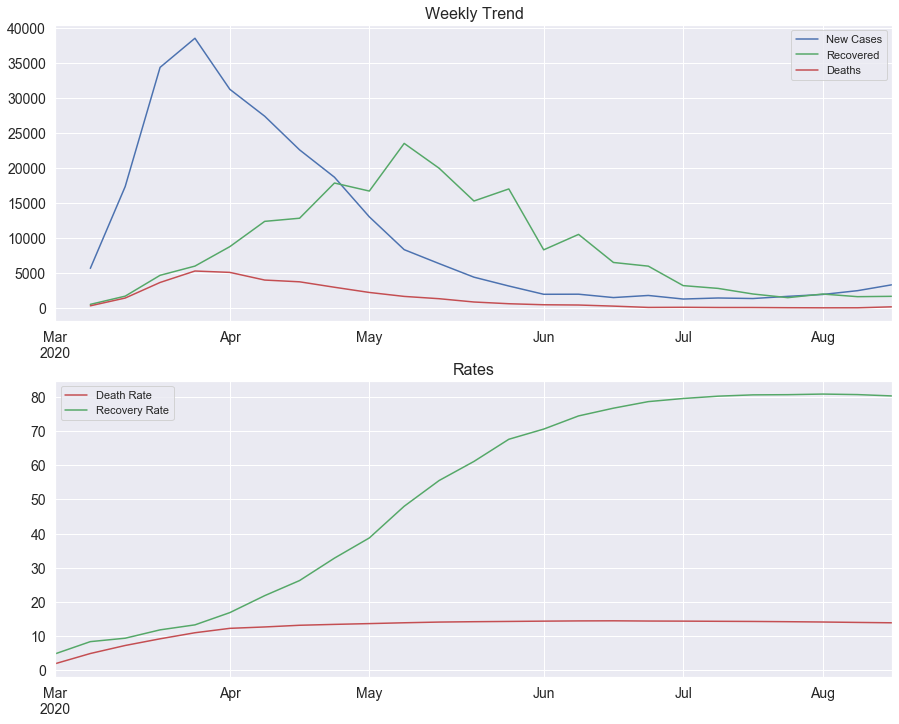

In [224]:
fig, axes = plt.subplots(2, 1, figsize=(15,12))
df_weekly_data = df_reg[["totale_casi", "dimessi_guariti", "deceduti"]].groupby(level=0).sum().asfreq("W")
df_weekly_trend = df_weekly_data - df_weekly_data.shift(+1)
df_weekly_trend.columns = ["New Cases", "Recovered", "Deaths"]

color_list = ["b", "g", "r"]
ax = df_weekly_trend.plot(title="Weekly Trend", ax=axes[0], color=color_list, fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

df_rates = df_weekly_data[["deceduti", "dimessi_guariti"]].div(df_weekly_data["totale_casi"], axis=0)*100
df_rates.columns = ["Death Rate", "Recovery Rate"]

color_list = ["r", "g"]
ax = df_rates.plot(title="Rates", ax=axes[1], color=color_list, fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)


We can observe a peak of new infected at the end of March (with almost 40 thousand of registered cases in a single week). Since then, the number of new infected continued to decline until June, when they stabilized at a few thousands of cases per week.  
The lockdown started in mid-March, and according to data it took about two weeks to show its results and about two months to get us out from the health emergency.

The precautions and the social distancing made sure that the contagion did not spread again after the end of the lockdown, but in the last weeks (the first of August) a new growth of infections had been registered. This is attributable to people returning from holidays in foreign country and not respecting the known rules on vacation.

We can also observe from the second chart that the death rate remained almost stable over the time.

## 4. Analysis of regional data